661 Final Project
Group number 1: Ayan Sengupta, Gabe Schulefand, Jake Jackson

1. Importing Libraries and Downloading data sets

In [2]:
# import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
# import data from air bnb insider into data frames 

## San Diego Listings Data (detailed)
san_diego_listings = pd.read_csv('https://data.insideairbnb.com/united-states/ca/san-diego/2024-12-23/data/listings.csv.gz', compression='gzip')
## San Diego Reviews Data (detailed)
san_diego_reviews = pd.read_csv('https://data.insideairbnb.com/united-states/ca/san-diego/2024-12-23/data/reviews.csv.gz', compression='gzip')
 

2. Exploring the Data and Data Cleaning
   
   link to the data dictionary to understand each column of the listings data: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=1322284596#gid=1322284596

   link to data dictionary to understand each column of the reviews data: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?gid=0#gid=0

In [4]:
## exploring the listings data
print(san_diego_listings.info())
print(san_diego_listings.head())
print(san_diego_listings.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12844 non-null  int64  
 1   listing_url                                   12844 non-null  object 
 2   scrape_id                                     12844 non-null  int64  
 3   last_scraped                                  12844 non-null  object 
 4   source                                        12844 non-null  object 
 5   name                                          12844 non-null  object 
 6   description                                   12638 non-null  object 
 7   neighborhood_overview                         8046 non-null   object 
 8   picture_url                                   12844 non-null  object 
 9   host_id                                       12844 non-null 

So listing has 12844 rows and 75 columns. A lot of these columns contain listing and host urls and images that are not useful for analysis. We will be dropping them. The calculated_* columns have no information about what they are in the dictionary and we will be dropping them as well.

In [5]:
calculated_columns = san_diego_listings.columns[san_diego_listings.columns.str.startswith('calculated_')]

## list of fields to be dropped
columns_to_drop = [
    'listing_url','license', 'scrape_id', 'last_scraped',
    'source', 'picture_url', 'host_url', 'host_name', 'host_thumbnail_url',
    'host_picture_url', 'host_since', 'host_location', 'host_has_profile_pic',
    'host_listings_count', 'host_neighbourhood', 'host_verifications','host_about','description',
    'neighborhood_overview', 'calendar_last_scraped','first_review','last_review', 'minimum_nights_avg_ntm','minimum_minimum_nights', 
    'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_nights_avg_ntm',
    'reviews_per_month'
] 
## get all the fields that start with calculated_ and add them to the columns_to_drop list
for i in calculated_columns:
    columns_to_drop.append(i)

## dropping columns that are not needed
san_diego_listings_cleaned = san_diego_listings.drop(columns=columns_to_drop)


we will now look at missing values and distributions for the remaining columns to analyze it further.

In [6]:
## looking at how many null values are in the data
print(san_diego_listings_cleaned.isnull().sum())

## looking at the data types for each column
print(san_diego_listings_cleaned.dtypes)


id                                  0
name                                0
host_id                             0
host_response_time               1461
host_response_rate               1461
host_acceptance_rate              941
host_is_superhost                 423
host_total_listings_count           0
host_identity_verified              0
neighbourhood                    4798
neighbourhood_cleansed              0
neighbourhood_group_cleansed    12844
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1184
bathrooms_text                      1
bedrooms                          204
beds                             1224
amenities                           0
price                            1184
minimum_nights                      0
maximum_nights                      0
calendar_updated                12844
has_availabi

neighbourhood_group_cleansed and calender_updated columns have only null values and nothing else and can hence be removed. further neighbourhoood_clensed is a more accurate version of neighbourhood hence the column neighborhood is removed. some of the other columns have a few null values but we will deal with those in a future step by either imputing those values.

In [7]:
san_diego_listings_cleaned = san_diego_listings_cleaned.drop(columns=['neighbourhood_group_cleansed','calendar_updated','neighbourhood'])

Some columns in the data frame are of the wrong type. host reponse time is an object (text) and will not be used (hence dropeed),host response rate and acceptance rates will have to converted to integrs, host identity verified will have to converted to boolean (1 for true, 0 for false). We do not look at property type as it is supplied by the lister and we are not dividing listings by property type. we will need to further analyze room_type and likely convert it into a dummy variable. bathroom_text provides no useful information when compared to bathrooms and hence is removed completly. price is of type object likely due to the '$' we will fix this. has availability will need to be converted to a binary instead of text. Finally instant_bookable will also have to converted to a binary column.

In [8]:
san_diego_listings_cleaned = san_diego_listings_cleaned.drop(columns=['host_response_time','property_type','bathrooms_text'])

In [9]:


## convert the host_response_rate and host_acceptance_rate columns to numeric
san_diego_listings_cleaned['host_response_rate'] = san_diego_listings_cleaned['host_response_rate'].str.replace('%','').astype(float)
san_diego_listings_cleaned['host_acceptance_rate'] = san_diego_listings_cleaned['host_acceptance_rate'].str.replace('%','').astype(float)

# convert host_identity_verified to a binary value
san_diego_listings_cleaned['host_identity_verified'] = san_diego_listings_cleaned['host_identity_verified'].replace({'t': 1, 'f': 0}).astype(int)

## convert price to a numeric value
san_diego_listings_cleaned['price'] = san_diego_listings_cleaned['price'].str.replace('$','').str.replace(',','').astype(float)

## has availibity contains some inf values - we will replace them with -1s
san_diego_listings_cleaned['has_availability'] = san_diego_listings_cleaned['has_availability'].replace({np.nan: -1 , np.inf: -1})
san_diego_listings_cleaned['has_availability'] = san_diego_listings_cleaned['has_availability'].replace({'t': 1, 'f': 0}).astype(int)

## conver instant_bookable to a binary value
san_diego_listings_cleaned['instant_bookable'] = san_diego_listings_cleaned['instant_bookable'].replace({'t': 1, 'f': 0}).astype(int)

## convert host_is_superhost to a binary value
san_diego_listings_cleaned['host_is_superhost'] = san_diego_listings_cleaned['host_is_superhost'].replace({np.nan: -1 , np.inf: -1})
san_diego_listings_cleaned['host_is_superhost'] = san_diego_listings_cleaned['host_is_superhost'].replace({'t': 1, 'f': 0}).astype(int)

## convert room_type to a dummy variables then rename them 
san_diego_listings_cleaned = pd.get_dummies(san_diego_listings_cleaned, columns=['room_type'], prefix='room_type')
san_diego_listings_cleaned = san_diego_listings_cleaned.rename(columns={'room_type_Entire home/apt': 'room_type_entire_home', 'room_type_Private room': 'room_type_private_room', 'room_type_Shared room': 'room_type_shared_room','room_type_Hotel room':'room_type_hotel_room'})




/tmp/ipykernel_289667/3021122410.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  san_diego_listings_cleaned['host_identity_verified'] = san_diego_listings_cleaned['host_identity_verified'].replace({'t': 1, 'f': 0}).astype(int)
/tmp/ipykernel_289667/3021122410.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  san_diego_listings_cleaned['has_availability'] = san_diego_listings_cleaned['has_availability'].replace({'t': 1, 'f': 0}).astype(int)
/tmp/ipykernel_289667/3021122410.py:16: FutureWarning: Downcasting behavior in `repla

Now with our primary cleaning done on the listings data set, lets look at missing values again

In [10]:
## look at missing values 
print(san_diego_listings_cleaned.isnull().sum())




id                                0
name                              0
host_id                           0
host_response_rate             1461
host_acceptance_rate            941
host_is_superhost                 0
host_total_listings_count         0
host_identity_verified            0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
accommodates                      0
bathrooms                      1184
bedrooms                        204
beds                           1224
amenities                         0
price                          1184
minimum_nights                    0
maximum_nights                    0
has_availability                  0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
number_of_reviews_ltm             0
number_of_reviews_l30d            0
review_scores_rating        

We will be imputing the missing values starting the host response rate and hoset acceptance rates. There are a few ways to do this - we are going to group the listing by what neighborhood they are in, then take a median of each groups response rate and acceptance rate and use that to fill the missing values.

In [11]:
## group by neighbourhood_clensed, then impute missing values with the median value per group 
san_diego_listings_cleaned['host_response_rate'] = san_diego_listings_cleaned.groupby('neighbourhood_cleansed')['host_response_rate'].transform(lambda x: x.fillna(x.median()))
san_diego_listings_cleaned['host_acceptance_rate'] = san_diego_listings_cleaned.groupby('neighbourhood_cleansed')['host_acceptance_rate'].transform(lambda x: x.fillna(x.median()))

## look at these two columns again to make sure we got all the missing values 
print(san_diego_listings_cleaned['host_acceptance_rate'].isnull().sum())
print(san_diego_listings_cleaned['host_response_rate'].isnull().sum())



0
0


next we will impute the missing values in batrooms, bedrooms and beds. We will use a similar approach to before but we will group by accomodates since that is usually a good indicator of how many rooms are in the property and then take a median of each group to fill the missing values.

In [12]:
columns_to_impute = ['bathrooms','bedrooms','beds']
for col in columns_to_impute:
    san_diego_listings_cleaned[col]=san_diego_listings_cleaned.groupby('accommodates')[col] \
        .transform(lambda x: x.fillna(x.median()))
    print(f"missing values in {col}:{san_diego_listings_cleaned[col].isnull().sum()}")




missing values in bathrooms:0
missing values in bedrooms:0
missing values in beds:0


Next we will impute the missing prices of the listings - the most logical way is to group the listings by neighbourhood since listing prices are usually tied to the neighnourhood and then fill the missing values with the median price of the group they belong to.

In [13]:
san_diego_listings_cleaned['price'] = san_diego_listings_cleaned.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.fillna(x.median()))
print(san_diego_listings_cleaned['price'].isnull().sum())

0


The last imputations left to do are review_scores_ratings, review_scores_accuracy,review_scores_cleanliness, review_scores_checkin, communication, location and value. sine we do not care of listings with no reviews for this project we drop the records with the missing values.

In [14]:
## remove the missing values
san_diego_listings_cleaned = san_diego_listings_cleaned.dropna(subset=['review_scores_rating'])

## look at missing value tallies
print(san_diego_listings_cleaned.isnull().sum())


id                             0
name                           0
host_id                        0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_total_listings_count      0
host_identity_verified         0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
amenities                      0
price                          0
minimum_nights                 0
maximum_nights                 0
has_availability               0
availability_30                0
availability_60                0
availability_90                0
availability_365               0
number_of_reviews              0
number_of_reviews_ltm          0
number_of_reviews_l30d         0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_sco

Lets plot a correlatin matrix with the remaining numerical features to see which ones are tighty correlated. We will drop features that are super tighly correlated since they will not add any value to our analysis.

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 12807
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10638 non-null  int64  
 1   name                         10638 non-null  object 
 2   host_id                      10638 non-null  int64  
 3   host_response_rate           10638 non-null  float64
 4   host_acceptance_rate         10638 non-null  float64
 5   host_is_superhost            10638 non-null  int64  
 6   host_total_listings_count    10638 non-null  int64  
 7   host_identity_verified       10638 non-null  int64  
 8   neighbourhood_cleansed       10638 non-null  object 
 9   latitude                     10638 non-null  float64
 10  longitude                    10638 non-null  float64
 11  accommodates                 10638 non-null  int64  
 12  bathrooms                    10638 non-null  float64
 13  bedrooms             

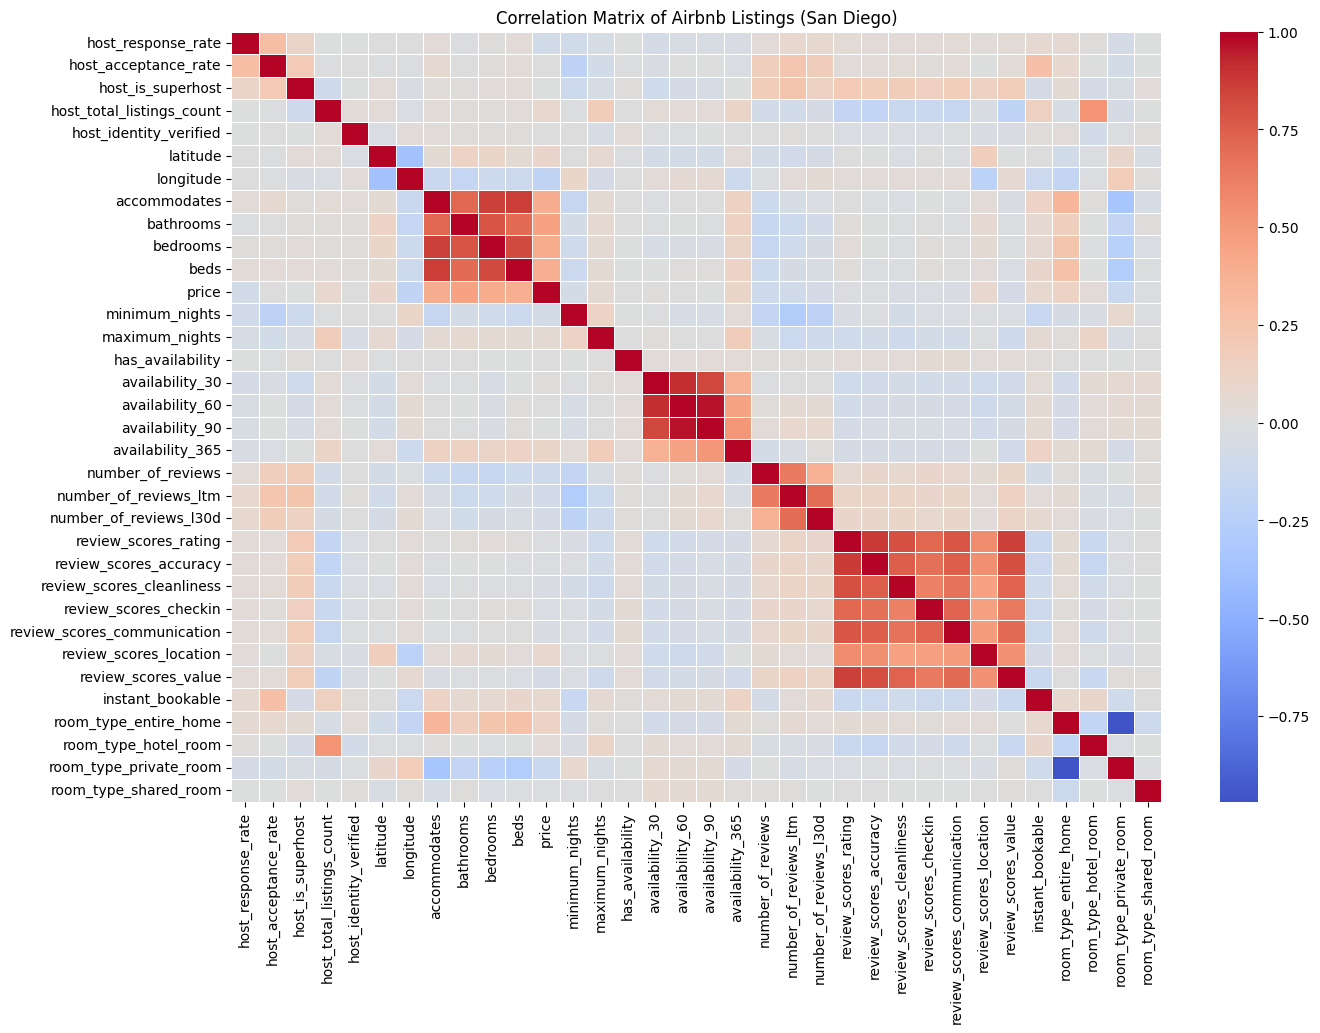

In [15]:
## following columns are either non numeric or unique identifier, we will exclude them for the correlation matrix
print(san_diego_listings_cleaned.info())
cols_to_exc = ['id','neighbourhood_cleansed','amenities','name','host_id']
cor_matrix_df = san_diego_listings_cleaned.drop(columns= cols_to_exc)
# Compute correlation matrix
corr_matrix = cor_matrix_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)

# Title
plt.title("Correlation Matrix of Airbnb Listings (San Diego)")
plt.show()

a) availability columns are tightly correlated. Dropping all of them except the availability_365.

b) accommodates, bathrooms, bedrooms, beds are all strongly positively correlated. All of these in some way measure capacity so this is not unusual. Since we will not be 
running any kind of prediction based on these, we will drop the beds column (bedrooms provide sufficient info in this case) and keep the rest.

c) number_of_reviews, number_of_reviews_ltm (last 12 months), number_of_reviews_l30d (last 30 days) are all strongly positively correlated. They all 
measure review volume, just over different time frames. Since we are only going to be looking at recent reviews, we will keep number_of_reviews_ltm.


In [17]:
## setting columns to drop
correlated_colums = ['availability_30','availability_60','availability_90','beds','number_of_reviews','number_of_reviews_l30d']
san_diego_listings_cleaned = san_diego_listings_cleaned.drop(columns=correlated_colums)

Now that we have removed super tightly coupled coulums lets look at the statistics of the numeriacal columns in the listings data.

In [18]:
print(san_diego_listings_cleaned.describe())

                 id       host_id  host_response_rate  host_acceptance_rate  \
count  1.063800e+04  1.063800e+04        10638.000000          10638.000000   
mean   4.774175e+17  1.667961e+08           98.453939             91.996334   
std    4.888592e+17  1.790876e+08            8.549459             17.929967   
min    6.000000e+00  2.900000e+01            0.000000              0.000000   
25%    3.279893e+07  2.395070e+07          100.000000             95.000000   
50%    5.733670e+17  8.291917e+07          100.000000             99.000000   
75%    9.349477e+17  2.974525e+08          100.000000            100.000000   
max    1.315611e+18  6.647825e+08          100.000000            100.000000   

       host_is_superhost  host_total_listings_count  host_identity_verified  \
count       10638.000000               10638.000000            10638.000000   
mean            0.517390                  77.838785                0.895187   
std             0.564391                 421.676277

In [ ]:
## exploring the reviews data
print(san_diego_reviews.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839296 entries, 0 to 839295
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     839296 non-null  int64 
 1   id             839296 non-null  int64 
 2   date           839296 non-null  object
 3   reviewer_id    839296 non-null  int64 
 4   reviewer_name  839294 non-null  object
 5   comments       839097 non-null  object
dtypes: int64(3), object(3)
memory usage: 38.4+ MB
None
